In [1]:
# import libraries 
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.patches as mpatches
import math

from sklearn.cluster import DBSCAN, OPTICS

In [2]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

my_colors_2 = ['#88292F', '#697268', '#12355B', '#D7816A', '#F46036', '#5386E4', '#FDE74C', '#9DBF9E']
custom_cmap_2 = LinearSegmentedColormap.from_list('custom_cmap', my_colors_2)

In [12]:
# import clean data set

df_wind = pd.read_csv('../../../data_analysis_and_preproc/intermediate/wind/final_wind_df.csv')

In [4]:
df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1
1,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1
2,11,2021-01-01 04:20:00,5.1,297.0,137.0,9.45,-3.0,10.0,1
3,11,2021-01-01 14:20:00,7.8,301.0,614.0,14.51,-2.0,11.0,1
4,11,2021-01-01 14:40:00,7.7,301.0,611.0,14.60,-2.0,10.0,1


# Density based clustering

## DBSCAN

In [5]:
X = df_wind.iloc[:,2:-1]

In [7]:
# Define the DBSCAN parameters
eps = 0.9
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit the model to the data
dbscan.fit(X)

# Get the labels of the data points
labels = dbscan.labels_


In [8]:
labels += 1

df_wind['cluster'] = labels

df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1,0
1,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1,0
2,11,2021-01-01 04:20:00,5.1,297.0,137.0,9.45,-3.0,10.0,1,0
3,11,2021-01-01 14:20:00,7.8,301.0,614.0,14.51,-2.0,11.0,1,0
4,11,2021-01-01 14:40:00,7.7,301.0,611.0,14.60,-2.0,10.0,1,0


In [9]:
df_wind['cluster'].unique()

array([   0,    1,    2, ..., 2748, 2749, 2754])

In [10]:
most_frequent_clusters = df_wind.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df_wind = df_wind.drop(columns='cluster')

df_wind = pd.merge(df_wind, most_frequent_clusters, on='asset_id', how='left')

df_wind.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,2021-01-01 00:00:00,8.3,296.0,802.0,15.51,-2.0,9.0,1,0
1,11,2021-01-01 00:20:00,8.1,298.0,666.0,14.88,-2.0,10.0,1,0
2,11,2021-01-01 04:20:00,5.1,297.0,137.0,9.45,-3.0,10.0,1,0
3,11,2021-01-01 14:20:00,7.8,301.0,614.0,14.51,-2.0,11.0,1,0
4,11,2021-01-01 14:40:00,7.7,301.0,611.0,14.60,-2.0,10.0,1,0


In [11]:
df_wind['cluster'].unique()

array([0])

In [12]:
df_wind.to_csv('results/DBSCAN.csv')

In [13]:
representative_points = df_wind.groupby(['asset_id']).first().reset_index()

/tmp/ipykernel_4190/2742180345.py:19: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette=my_colors, s=100)


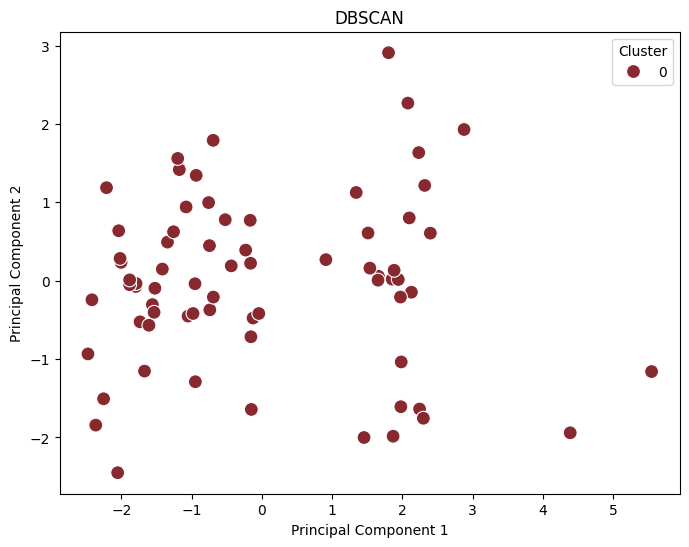

In [39]:
features = ['wind_speed', 'wind_direction', 'power_average', 'rotation_average', 'exterior_temperature', 'nacelle_temperature']

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(representative_points[features])

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Create DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Add 'cluster' column back to DataFrame
pca_df['cluster'] = representative_points['cluster']

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette=my_colors, s=100)
plt.title('DBSCAN')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [7]:
transform_df = df_wind.drop(columns=['asset_id', 'read_at', 'farm'])
transform_df['cluster'].unique()

array([0])

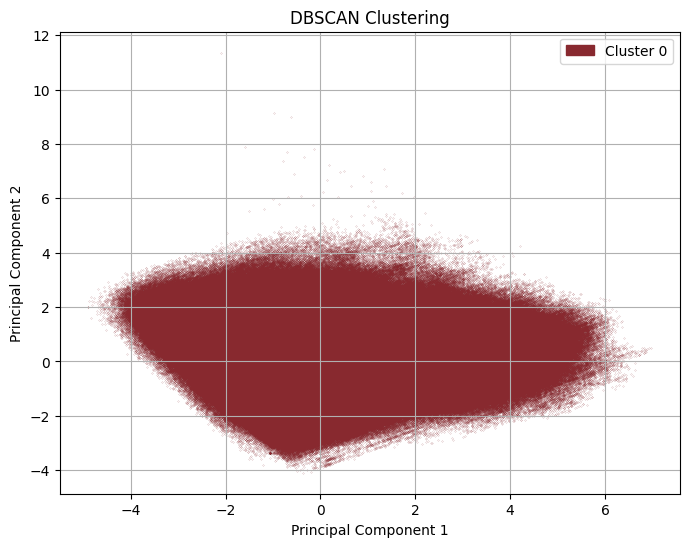

In [8]:
plt.figure(figsize=(8, 6))

transform_df = df_wind.drop(columns=['asset_id', 'read_at', 'farm'])

scaler = StandardScaler()
transform_df_scaled = scaler.fit_transform(transform_df)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(transform_df_scaled)

labels = transform_df['cluster']

# Iterate over unique cluster labels
for i, cluster_label in enumerate(np.unique(labels)):
    # Filter data points belonging to the current cluster
    cluster_mask = (labels == cluster_label)
    cluster_data = X_pca[cluster_mask]
    
    # Plot data points for the current cluster
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=0.01, label=f'Cluster {cluster_label}', color='#88292F')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)])
plt.grid(True)
plt.show()

this behaviour was expected due to the already known faults of density based algorithms in high dimensional data, large data sets and relatively equal density